### Healthcare app reviews

- airline reviews have a large number of training data, hence this dataset should be large as well
- This dataset contains user reviews of healthcare apps, along with associated information such as usernames, review content, ratings, and dates, making it a comprehensive resource for analysis and insights.

With an broad variety of reviews that span many different social platfoms, healthcare providers struggle to analyse each review to uncover satisfactory or unsatisfactory aspects highlighted by users.

Therefore, by developing an RNN-based sentiment prediction model tailored to healthcare app reviews, these organizations can streamline the process of labelling sentiment for both historical and upcoming reviews.

Healthcare providers will be able to perform aspect analysis, user behavior analysis, and understanding the overall user satisfaction with these apps

In [1]:
# pip install transformers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/ADL/assignment23aug/healthcareApp.zip

Archive:  /content/drive/MyDrive/ADL/assignment23aug/healthcareApp.zip
  inflating: reviews.csv             


In [3]:
import os
import shutil
import tensorflow as tf

from datetime import datetime
import tensorflow as tf

In [4]:
import pandas as pd

# read dataset
df = pd.read_csv('reviews.csv')

In [5]:
df.head()

,Healthcare App,Username,Content,Rating,Date
0,Mfine,shoeb ansari,Bad lab test service. Technician doesn't come ...,1,12-06-2023 15:15
1,Mfine,Hardik Shah,great user interaction and great support team.,5,12-06-2023 07:12
2,Mfine,pooja mehta,It was a very bad experience....Now I will not...,1,11-06-2023 13:54
3,Mfine,Kuldeep Verma,very nice service,5,11-06-2023 08:14
4,Mfine,Anamika Singh,Fraud people minting money,1,11-06-2023 06:27


In [6]:
df = df.sample(n=15000)  # to allow for model training on 16gb RAM with T4 GPU

In [7]:
print(f'Total number of reviews is {df.shape[0]}')
print(f'Number of classes is \n {df.Rating.value_counts()}')

Total number of reviews is 15000
Number of classes is 
 5    9165
1    3171
4    1791
3     515
2     358
Name: Rating, dtype: int64


converting sentiment into 3 classes

In [8]:
def sentimentname(tt):
  if tt <3:
    return 'Negative'
  elif tt > 3:
    return 'Positive'
  else:
    return 'Neutral'


df['Rating'] = df['Rating'].apply(lambda x: sentimentname(x))

In [9]:
df.Rating.value_counts()

Positive    10956
Negative     3529
Neutral       515
Name: Rating, dtype: int64

### split dataset into training and testing datasets


In [12]:
# split data into training and test dataset
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=0)

# Separate out our target values
y_train = train['Rating'].tolist()
y_test = test['Rating'].tolist()

# Separate out text data
x_train = train['Content'].tolist()
x_test = test['Content'].tolist()


print('size of test set is ', len(x_test))

size of test set is  3000


In [13]:
print(f'Number of classes in training data \n {train.Rating.value_counts()}')

Number of classes in training data 
 Positive    8776
Negative    2813
Neutral      411
Name: Rating, dtype: int64


> The trianing data is significantly imbalanced, with around 8300 rows difference between positive and neutral class

### preprocess data

In [16]:
x_train[:5]

["Since there is no negative star, I am giving 1 star. Worst service, please don't install. Our prefer respective neighborhood pharmacy shops. I have ordered 4 medicines to my Mom, they have delivered only 1 and other 3 are not delivered since 1 week. No response from customer care even after raising ticket",
 'I love my mom',
 'Superb',
 'usefu',
 'very useful app']

In [17]:
y_train[:5]

['Negative', 'Positive', 'Positive', 'Positive', 'Positive']

In [18]:
# transform target column from text to numerical values
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras as keras
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the label column
y_train_labelled = label_encoder.fit_transform(y_train)
y_test_labelled= label_encoder.fit_transform(y_test)

# Turn our scalar targets into binary categories
num_classes = 3
y_train = keras.utils.to_categorical(y_train_labelled, num_classes)
y_test = keras.utils.to_categorical(y_test_labelled, num_classes)

In [19]:
y_train[:10]

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [20]:
# create tf.data.dataset freom value lists
import numpy as np

batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices((np.array(x_train), y_train)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((np.array(x_test),y_test)).batch(batch_size)

In [21]:
for text_batch, label_batch in test_dataset.take(1): # take one batch
    for i in range(3):
        print(label_batch[i].numpy(), text_batch[i].numpy())

[0. 0. 1.] b'Very good'
[1. 0. 0.] b'Medicine are never available worst app Worst support'
[0. 0. 1.] b'The overall UI and UX is smooth and flawless. Services at ground too, quite trustworthy.'


- Negative : 0
- Neutral : 1
- Positive : 2



In [22]:
len(train_dataset)

94

configure dataset

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Next, define the dataset preprocessing steps required for your sentiment classification model. Initialize a TextVectorization layer with the desired parameters to vectorize reviews.

In [24]:
# Vocabulary size and number of words in a sequence.
VOCAB_SIZE = 10000  # number of unique words, larger = more complex
MAX_SEQUENCE_LENGTH = 200
# Use the text vectorization layer to normalize, split, and map strings to
# integers.
# Set maximum_sequence length as all samples are not of the same length. if sentence is more than max seq length, cut off sentence
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)


# sequence_length = 128
# input_features = 256
# vocab_size = 10000
# batch_size = 64

# train_dataset = tf.data.Dataset.from_tensor_slices((tf.random.uniform((batch_size, sequence_length, input_features)), tf.random.uniform((batch_size,))))
# test_dataset = tf.data.Dataset.from_tensor_slices((tf.random.uniform((batch_size, sequence_length, input_features)), tf.random.uniform((batch_size,))))


In [25]:
print(len(vectorize_layer.get_vocabulary())) # select words based on feature importance

10000


### create a multiclass classification model (neutral, positive, neutral) using the same layers as the previous model (part2.ipynb)

In [26]:
EMBEDDING_DIM = 128
num_classes = 3  # Number of sentiment classes

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,
                              output_dim=EMBEDDING_DIM,
                              mask_zero=True,
                              name='embedding'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])



In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [28]:
#Create an instance of Stochastic Gradient Descent (SGD) optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.8)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [29]:
# use early stoppingg callback to stop training when there is no improvement after x number of epochs
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, verbose=0,
    mode='auto', restore_best_weights=True)

Compute class weights, to account for imbalanced training data

In [30]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weights = {cls: total_samples / (num_classes * count) for cls, count in enumerate(class_counts)}



In [31]:
hist = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    callbacks=[earlystop_callback],
    class_weight=class_weights)

Epoch 1/20
94/94 [==============================] - 46s 266ms/step - loss: 1.0572 - accuracy: 0.5008 - val_loss: 1.0121 - val_accuracy: 0.6490
Epoch 2/20
94/94 [==============================] - 8s 82ms/step - loss: 0.9849 - accuracy: 0.6996 - val_loss: 0.9533 - val_accuracy: 0.6803
Epoch 3/20
94/94 [==============================] - 6s 67ms/step - loss: 0.9727 - accuracy: 0.7072 - val_loss: 0.9568 - val_accuracy: 0.6713
Epoch 4/20
94/94 [==============================] - 7s 78ms/step - loss: 0.9625 - accuracy: 0.7097 - val_loss: 0.9046 - val_accuracy: 0.6453
Epoch 5/20
94/94 [==============================] - 12s 128ms/step - loss: 0.9503 - accuracy: 0.7238 - val_loss: 0.8389 - val_accuracy: 0.7440
Epoch 6/20
94/94 [==============================] - 5s 57ms/step - loss: 0.9182 - accuracy: 0.7432 - val_loss: 0.7991 - val_accuracy: 0.7670
Epoch 7/20
94/94 [==============================] - 7s 77ms/step - loss: 0.8690 - accuracy: 0.7887 - val_loss: 0.8163 - val_accuracy: 0.7577
Epoch 8/2

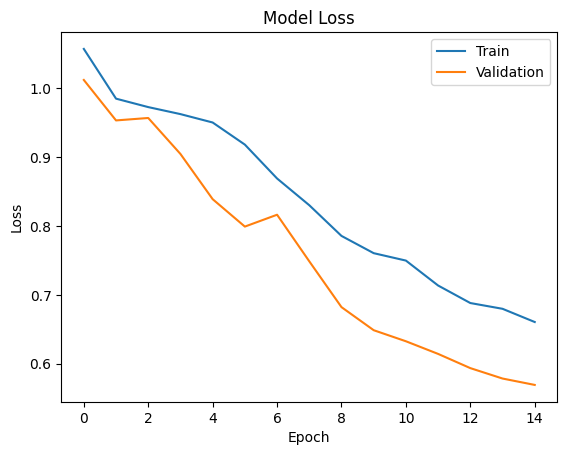

In [32]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Evaluation of the model on healthcare app reviews test dataset

In [33]:
import numpy as np
from sklearn.metrics import classification_report

y_preds = []
y_labels = []

for texts, labels in test_dataset:
    preds = model.predict(texts)
    preds_classes = np.argmax(preds, axis=1)  # Get the index of the class with the highest probability
    y_preds.extend(preds_classes)

    # Convert one-hot encoded labels to integer format
    labels_int = np.argmax(labels.numpy(), axis=1)
    y_labels.extend(labels_int)


print(classification_report(y_labels, y_preds))


2/2 [==============================] - 5s 17ms/step
              precision    recall  f1-score   support

           0       0.93      0.69      0.79       716
           1       0.06      0.31      0.10       104
           2       0.95      0.85      0.90      2180

    accuracy                           0.79      3000
   macro avg       0.65      0.61      0.60      3000
weighted avg       0.92      0.79      0.84      3000



In [40]:
unique, counts = np.unique(y_train_labelled, return_counts=True)

print('Class counts in training dataset \n',np.asarray((unique, counts)).T)

Class counts in training dataset 
 [[   0 2813]
 [   1  411]
 [   2 8776]]


> Overall, the model is able to predict most values correctly, with an accuracy of 79%.

- From the F1-score of class 2 and the F1-score of class 1, it is evident that even with class weights, the model is biased towards the majority class.

- Class 2 has high precision (0.95) and recall (0.85), implying that the model performs well in predicting Class 2 instances.

- Class 1 has low precision (0.06) and relatively better recall (0.31), suggesting that the model captures some instances of Class 1, but most of its predictions are incorrect.

- For Class 0, the model achieves high precision (0.93) but lower recall (0.69), indicating that when it predicts Class 0, it's often correct, but it is unable to identify a significant portion of actual Class 0 instances.


> The macro average differs from the weighted average by a large amount.
macro average gives equal weight to all classes, while the weighted average takes requencies of values in each class into account.


### Evaluation of the model on airline reviews dataset



In [34]:
!unzip /content/drive/MyDrive/ADL/assignment23aug/twitterUSairline.zip

Archive:  /content/drive/MyDrive/ADL/assignment23aug/twitterUSairline.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


In [35]:
df = pd.read_csv('Tweets.csv')

In [36]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [37]:
test_ds = df['text'].tolist()[:100] # use first 100 values for testing to prevent excessive use of RAM
test_labels = df['airline_sentiment'].tolist()[:100]
test_labels = label_encoder.fit_transform(test_labels)

In [38]:
y_preds = []
y_labels = []

for index, tt in enumerate(test_ds):
  pred = model.predict([tt])
  y_preds.append(np.argmax(pred))
  y_labels.append(test_labels[index])


1/1 [==============================] - 0s 60ms/step


In [39]:

print(classification_report(y_labels, y_preds))

              precision    recall  f1-score   support

           0       0.73      0.31      0.44        35
           1       0.45      0.79      0.57        38
           2       0.67      0.44      0.53        27

    accuracy                           0.53       100
   macro avg       0.62      0.52      0.51       100
weighted avg       0.61      0.53      0.52       100



> The model's accuracy drops significantly when predicting data from the airline reviews dataset (0.53).

This shows that the model is not able to generalise well on another dataset, most likely due to the model being trained on a dataset of a different domain.

### Improvement in training data

> When previously trained with a training dataset of 1100 rows, the accuracy constantly stayed at 0.45. Hence, i sourced for a larger dataset, which is the current dataset, that has more data than the airline sentiment dataset.
>- Since the data is imbalanced among the 3 classes in the training data, I utilized class weights for the model to assign weights for each class. This helps the model to assign larger weights to minority classes during the trianing process.


> Hence, the resulting accuracy on the healthcare review test dataset is much better, as the large amount of training data allows for a more robust and generalizable model.



---

